In [15]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display 


# Pretty display for notebooks
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

dataset = pd.read_csv("datasets/dataset_clean.csv.gz", compression='gzip')
dataset['RIESGO_VIDA'] = np.where(dataset['RIESGO_VIDA'] == 'si', 1,0)
dataset = dataset.drop(['Unnamed: 0'], axis = 1)
display(dataset.head(n = 5))

labels_raw = dataset[['RIESGO_VIDA']]
features_raw = dataset.drop(['RIESGO_VIDA'], axis = 1)

,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PET_DPTO,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_ESTADO,PQR_TIPOATENCION,PQR_TIPOPETICION,RIESGO_VIDA,TRIM
0,bogota d.c.,de 13 a 17 años,ninguno,mujer,no aplica,bogotá,otro,no aplica,subsidiado,natural,...,bogota d.c.,bogotá,juridica,escrito,pqr,cerrado,peticion directa,reclamo,0,trim i
1,nariño,de 0 a 5 años,ninguno,hombre,no aplica,puerres,otro,no aplica,subsidiado,natural,...,nariño,puerres,natural,telefonico,pqr,cerrado,0,reclamo,0,trim i
2,valle,de 13 a 17 años,secundaria,hombre,no aplica,cali,abuelo (a),no aplica,contributivo,natural,...,valle,cali,natural,telefonico,pqr,cerrado,0,reclamo,0,trim i
3,huila,de 13 a 17 años,universitario incompleto,hombre,no aplica,neiva,padre,no aplica,contributivo,natural,...,huila,neiva,natural,personalizado,pqr,cerrado,0,reclamo,0,trim i
4,risaralda,de 13 a 17 años,ninguno,hombre,no aplica,dosquebradas,padre,persona en condición de discapacidad,contributivo,natural,...,risaralda,dosquebradas,natural,personalizado,pqr,pendiente (avance),0,reclamo,1,trim i


# Data Exploration

## Features Class Distribution

In [16]:

def getFeaturesDistribution(features):
    dfColumns = pd.DataFrame(columns=['Feature','Distinct Values'])
    for colName in features.columns.values:
        dfColumns = dfColumns.append({'Feature': colName, 'Distinct Values': features[colName].unique().size}, ignore_index=True)
    return dfColumns.infer_objects()
dfColumns = getFeaturesDistribution(features_raw)
display(dfColumns)



,Feature,Distinct Values
0,AFEC_DPTO,36
1,AFEC_EDADR,11
2,AFEC_EDUC,10
3,AFEC_GENERO,4
4,AFEC_GETNICO,10
5,AFEC_MPIO,1299
6,AFEC_PARENTESCO,18
7,AFEC_POBESPECIAL,10
8,AFEC_REGAFILIACION,7
9,AFEC_TIPOPER,4


In [17]:
dfColumns.describe()

,Distinct Values
count,42.000000
mean,420.666667
std,1417.728700
min,2.000000
25%,8.250000
50%,26.500000
75%,214.250000
max,9029.000000


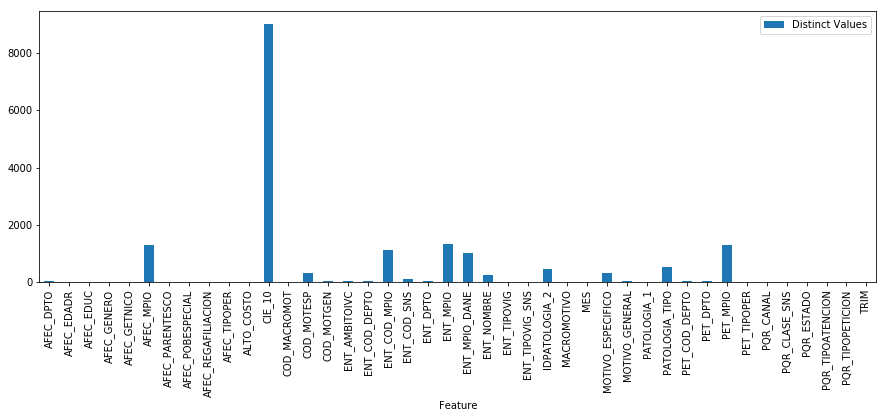

In [18]:
def showFeaturesDistribution(dfColumns):
    dfFeatures = dfColumns.copy(deep=True)
    dfFeatures.set_index("Feature",drop=True,inplace=True)
    dfFeatures.plot( kind='bar', figsize = (15,5))
    
showFeaturesDistribution(dfColumns)

### Shared Features

Location features share the same meaning: State/City values are inclusive. 

* AFEC_DPTO/AFEC_MPIO
* ENT_COD_DEPTO/ENT_COD_MPIO
* ENT_DPTO/ENT_MPIO
* PET_DPTO/PET_MPIO.

ENT_COD_DEPTO/ENT_COD_MPIO are codes for the descriptions features ENT_DPTO/ENT_MPIO, so one og the pairs can be removed from the dataset, we'll keep the codes and loose the descriptions.

Motive features are also codependent: 
* COD_MACROMOT/COD_MOTGEN/COD_MOTESP
* MACROMOTIVO/MOTIVO_GENERAL/MOTIVO_ESPECIFICO

COD_MACROMOT/COD_MOTGEN/COD_MOTESP are codes for the descriptions features MACROMOTIVO/MOTIVO_GENERAL/MOTIVO_ESPECIFICO, so one of the tuples can be removed from the dataset, we'll keep the codes and loose the descriptions.

In [19]:
#Merging Shared Features
def merge_features(row):
    row['AFEC_LOCATION'] = row['AFEC_DPTO'] + row['AFEC_MPIO']
    row['ENT_LOCATION'] = row['ENT_COD_DEPTO'] + row['ENT_COD_MPIO']
    row['PET_LOCATION'] = row['PET_DPTO'] + row['PET_MPIO']
    row['COMPLETE_MOTIVE'] = row['COD_MACROMOT'] + row['COD_MOTGEN'] + row['COD_MOTESP']
        
#features_raw.apply (lambda row: merge_features (row),axis=1)
features_raw['AFEC_LOCATION'] = features_raw['AFEC_DPTO'] + features_raw['AFEC_MPIO']
features_raw['ENT_LOCATION'] = features_raw['ENT_COD_DEPTO'] + features_raw['ENT_COD_MPIO']
features_raw['PET_LOCATION'] = features_raw['PET_DPTO'] + features_raw['PET_MPIO']
features_raw['COMPLETE_MOTIVE'] = features_raw['COD_MACROMOT'] + features_raw['COD_MOTGEN'] + features_raw['COD_MOTESP']
# Removing redundant features
features_raw = features_raw.drop(['ENT_DPTO', 'ENT_MPIO','MACROMOTIVO', 'MOTIVO_GENERAL', 'MOTIVO_ESPECIFICO','AFEC_DPTO', 'AFEC_MPIO', 'ENT_COD_DEPTO', 'ENT_COD_MPIO', 'PET_DPTO', 'PET_MPIO', 'COD_MACROMOT', 'COD_MOTGEN', 'COD_MOTESP'], axis = 1)

display()


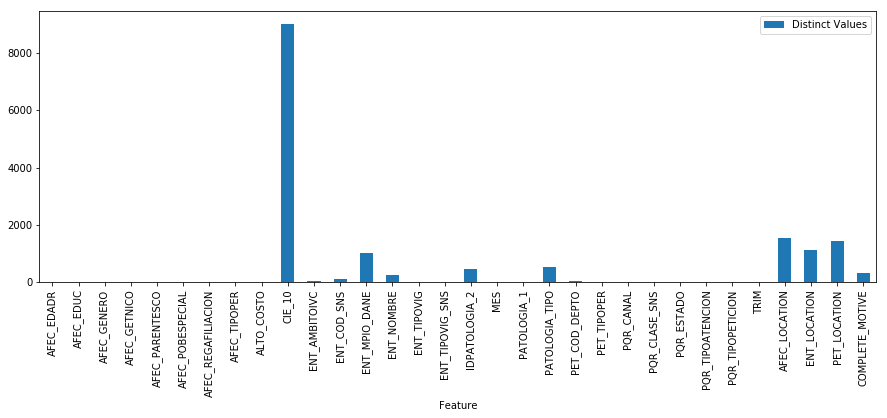

In [20]:
dfColumns = getFeaturesDistribution(features_raw)
showFeaturesDistribution(dfColumns)

In [15]:
featuresCategorical = dfColumns[dfColumns['Distinct Values'] <= 20]['Feature'].values.tolist()

In [16]:
featuresContinous = dfColumns[dfColumns['Distinct Values'] > 20]['Feature'].values.tolist()

In [19]:
from __future__ import division
# TODO: Total number of records
n_records = dataset['RIESGO_VIDA'].count()

# TODO: Number of records where individual's life is at risk
life_risk = dataset[dataset["RIESGO_VIDA"] == 1]
n_life_risk = life_risk['RIESGO_VIDA'].count()

# TODO: Number of records where individual's life is not at risk
no_life_risk =  dataset[dataset["RIESGO_VIDA"] == 0]
n_no_life_risk = no_life_risk['RIESGO_VIDA'].count()

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_life_risk/n_records)*100

# Print the results
print "Total number of records: {:,}".format(n_records)
print "Individuals with life at risk: {:,}".format(n_life_risk)
print "Individuals with life not at risk: {:,}".format(n_no_life_risk)
print "Percentage of individuals with life at risk: {:.2f}%".format(greater_percent)

Total number of records: 2,130,783
Individuals with life at risk: 288,811
Individuals with life not at risk: 1,841,972
Percentage of individuals with life at risk: 13.55%


## Encoding dataset

All features in the dataset are categorical. Some of them have too many classes to be one hot encoded. Mean encoding transformation will be perform on the dataset to encode features instead hot encoding it.

In [24]:
display(features_raw[featuresContinous])

,AFEC_DPTO,AFEC_MPIO,ALTO_COSTO,CIE_10,COD_MOTESP,COD_MOTGEN,ENT_AMBITOIVC,ENT_COD_DEPTO,ENT_COD_MPIO,ENT_COD_SNS,...,ENT_NOMBRE,ENT_TIPOVIG,IDPATOLOGIA_2,MOTIVO_ESPECIFICO,MOTIVO_GENERAL,PATOLOGIA_1,PATOLOGIA_TIPO,PET_COD_DEPTO,PET_DPTO,PET_MPIO
0,bogota d.c.,bogotá,0,otra atención médica,10115,101,otros,63,63130,epss03,...,cafesalud,regimen subsidiado,0.0,falta de oportunidad para la prestacion de servicios de laboratorio clinico y anatomo-patologia,restriccion en el acceso por falta de oportunidad para la atencion,problemas relacionados con facilidades de atencion medica u otros servicios de salud,problemas relacionados con facilidades de atencion medica u otros servicios de salud,11,bogota d.c.,bogotá
1,nariño,puerres,0,0,10109,101,0,52,52573,ess118,...,emssanar,regimen subsidiado,0.0,falta de oportunidad en la asignacion de citas de consulta medica especializada de otras especialidades medicas,restriccion en el acceso por falta de oportunidad para la atencion,problemas relacionados con facilidades de atencion medica u otros servicios de salud,problemas relacionados con facilidades de atencion medica u otros servicios de salud,52,nariño,puerres
2,valle,cali,0,"asma, no especificada",10314,103,0,76,76001,eps002,...,salud total,regimen contributivo,0.0,demora de la autorizacion de examenes de laboratorio o diagnosticos,restriccion en el acceso por demoras en la autorizacion,problemas relacionados con facilidades de atencion medica u otros servicios de salud,problemas relacionados con facilidades de atencion medica u otros servicios de salud,76,valle,cali
3,huila,neiva,0,agentes virales como causa de enfermedades clasificadas en otros capítulos,10613,106,0,41,41001,eps016,...,coomeva,regimen contributivo,0.0,barreras de acceso en la afiliacion (tramites no contemplados por la ley),restriccion en el acceso por fallas en la afiliacion,problemas relacionados con facilidades de atencion medica u otros servicios de salud,problemas relacionados con facilidades de atencion medica u otros servicios de salud,41,huila,neiva
4,risaralda,dosquebradas,0,epilepsia y sindromes epilepticos idiopaticos generalizados,10119,101,0,66,66001,eps003,...,cafesalud,regimen contributivo,0.0,falta de oportunidad en la entrega de medicamentos pos,restriccion en el acceso por falta de oportunidad para la atencion,enfermedaes neurologicas,epilepsia,66,risaralda,dosquebradas
5,caldas,manizales,0,0,10109,101,0,17,17001,eps002,...,salud total,regimen contributivo,0.0,falta de oportunidad en la asignacion de citas de consulta medica especializada de otras especialidades medicas,restriccion en el acceso por falta de oportunidad para la atencion,problemas relacionados con facilidades de atencion medica u otros servicios de salud,problemas relacionados con facilidades de atencion medica u otros servicios de salud,17,caldas,manizales
6,bogota d.c.,bogotá,0,otra atención médica,10611,106,otros,11,11001,epss34,...,capital salud,regimen subsidiado,0.0,negacion afiliacion,restriccion en el acceso por fallas en la afiliacion,problemas relacionados con facilidades de atencion medica u otros servicios de salud,problemas relacionados con facilidades de atencion medica u otros servicios de salud,11,bogota d.c.,bogotá
7,santander,bucaramanga,0,"desgarro del cartilago articular de la rodilla, presente",10116,101,0,68,68001,eps002,...,salud total,regimen contributivo,0.0,falta de oportunidad en la programacion de cirugia,restriccion en el acceso por falta de oportunidad para la atencion,problemas relacionados con facilidades de atencion medica u otros servicios de salud,problemas relacionados con facilidades de atencion medica u otros servicios de salud,68,santander,bucaramanga
8,bogota d.c.,bogotá,0,otra atención médica,10101,101,otros,11,11001,eps002,...,salud total,regimen contributivo,0.0,falta de oportunidad en la asignacion de citas de consulta medica general,restriccion en el acceso por falta de oportunidad para la atencion,problemas relacionados con facilidades de at

In [25]:
from category_encoders import *
import time


start_time = time.time()   
enc = TargetEncoder(cols=featuresContinous, return_df = True).fit(features_raw[featuresContinous], labels_raw)
dataset_encoded = enc.transform(features_raw[featuresContinous])
print("--- %s seconds ---" % (time.time() - start_time))

display(dataset_encoded.head(n = 5))  


--- 1904.15689802 seconds ---


,AFEC_DPTO,AFEC_MPIO,ALTO_COSTO,CIE_10,COD_MOTESP,COD_MOTGEN,ENT_AMBITOIVC,ENT_COD_DEPTO,ENT_COD_MPIO,ENT_COD_SNS,...,ENT_NOMBRE,ENT_TIPOVIG,IDPATOLOGIA_2,MOTIVO_ESPECIFICO,MOTIVO_GENERAL,PATOLOGIA_1,PATOLOGIA_TIPO,PET_COD_DEPTO,PET_DPTO,PET_MPIO
0,0.172465,0.171278,0.129512,0.061950,0.255345,0.203051,0.110250,0.221341,0.170139,0.370885,...,0.332720,0.262811,0.118901,0.255345,0.203051,0.151759,0.151759,0.122722,0.122722,0.175819
1,0.199864,0.163793,0.129512,0.091583,0.156412,0.203051,0.124861,0.193337,0.126582,0.292325,...,0.294776,0.262811,0.118901,0.156412,0.203051,0.151759,0.151759,0.146529,0.146529,0.106796
2,0.221915,0.217327,0.129512,0.384615,0.230204,0.449348,0.124861,0.200269,0.211707,0.147399,...,0.169073,0.208002,0.118901,0.230204,0.449348,0.151759,0.151759,0.144960,0.185777,0.149912
3,0.299221,0.334056,0.129512,0.016157,0.104876,0.121258,0.124861,0.292689,0.345899,0.186514,...,0.193458,0.208002,0.118901,0.104876,0.121258,0.151759,0.151759,0.234090,0.234090,0.261161
4,0.208638,0.217398,0.129512,0.795501,0.285007,0.203051,0.124861,0.201237,0.213673,0.259552,...,0.332720,0.208002,0.118901,0.285007,0.203051,0.404018,0.404018,0.151495,0.151495,0.164382


In [ ]:
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches

def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """

    # Create figure
    fig = pl.figure(figsize = (11,60));

    # Skewed feature plotting
    for i, feature in enumerate(features_columns):
        ax = fig.add_subplot(23, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000000))
        ax.set_yticks([0, 500000, 1000000, 1500000, 2000000])
        ax.set_yticklabels([0, 500000, 1000000, 1500000, ">2000000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

In [ ]:
distribution(dataset_encoded)

In [ ]:

# Log-transform the skewed features
skewed = features_columns
features_log_transformed = dataset_encoded.apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
distribution(features_log_transformed, transformed = True)

In [ ]:

# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)


features_log_minmax_transform = features_log_transformed
features_log_minmax_transform = scaler.fit_transform(features_log_transformed)

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

In [62]:
features_log_transformed['RIESGO_VIDA'] = dataset['RIESGO_VIDA']
features_log_transformed.to_csv("datasets/dataset_encoded.csv", encoding='utf-8')